1. Подготовка данных
    1. проверить наличие пропусков и выбросов
    2. привести категориальные признаки к числовым
    3. вычислить парные корреляции признаков
2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
    1. аналитически (реализовать самому)
    2. численно, с помощью методов градиентного спуска  (реализовать самому)
3. Добавление регуляризации

    Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:

    1. аналитически
    2. численно
4. Оценка обобщающей способности

    Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:

    1. константную - прогноз средним значением
    2. из пункта 2
    3. из пункта 3

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import erf
import seaborn as sns
import math

In [180]:
df_train = pd.read_csv("/content/insurance_train.csv")
df_test = pd.read_csv("/content/insurance_test.csv")

In [181]:
print(df_train.head())
print(df_test.head())

   age     sex     bmi  children smoker     region      charges
0   26    male  27.060         0    yes  southeast  17043.34140
1   58    male  36.955         2    yes  northwest  47496.49445
2   20  female  24.420         0    yes  southeast  26125.67477
3   51  female  38.060         0    yes  southeast  44400.40640
4   62  female  25.000         0     no  southwest  13451.12200
   age     sex     bmi  children smoker     region      charges
0   61    male  38.380         0     no  northwest  12950.07120
1   59  female  34.800         2     no  southwest  36910.60803
2   31    male  30.875         0     no  northeast   3857.75925
3   24  female  33.345         0     no  northwest   2855.43755
4   31    male  28.500         5     no  northeast   6799.45800


In [182]:
print("Названия колонок:")
print(df_train.columns.tolist())

print("\nТипы данных:")
print(df_train.dtypes)


Названия колонок:
['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Типы данных:
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


# 1

In [183]:
numerical_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Числовые признаки:", numerical_cols)

categorical_cols = df_train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Категориальные признаки:", categorical_cols)


Числовые признаки: ['age', 'bmi', 'children', 'charges']
Категориальные признаки: ['sex', 'smoker', 'region']


In [184]:
missing_values = df_train.isnull().sum()

print("Пропуски по столбцам:")
print(missing_values[missing_values > 0])


Пропуски по столбцам:
Series([], dtype: int64)


In [185]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

for col in numerical_cols:
    outliers = detect_outliers_iqr(df_train, col)
    print(f"Выбросы в '{col}': {outliers.shape[0]}")


Выбросы в 'age': 0
Выбросы в 'bmi': 5
Выбросы в 'children': 0
Выбросы в 'charges': 19


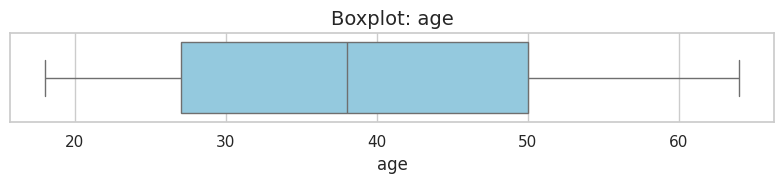

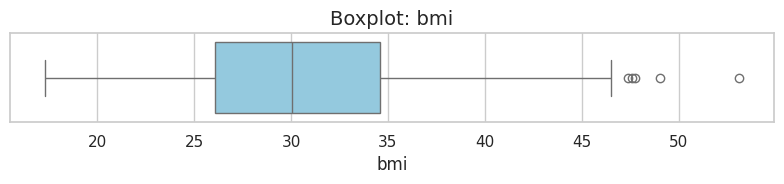

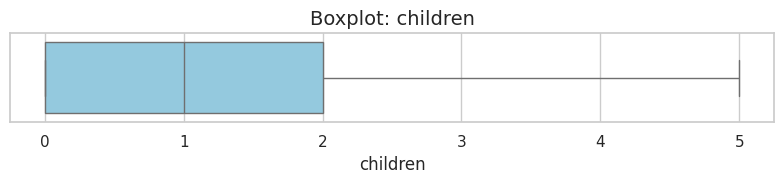

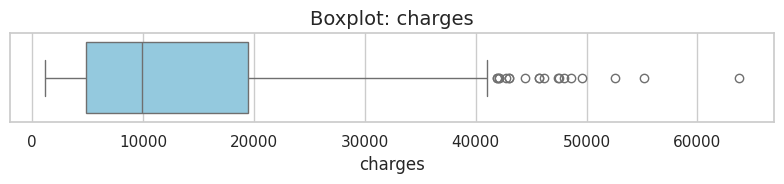

In [186]:
numerical_cols = ['age', 'bmi', 'children', 'charges']
sns.set(style="whitegrid")
for col in numerical_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_train[col], color="skyblue")
    plt.title(f"Boxplot: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [187]:
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

numerical_cols = df_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_train_clean = remove_outliers_iqr(df_train, numerical_cols)

print("Размер до очистки:", df_train.shape)
df_train = df_train_clean
print("Размер после очистки:", df_train.shape)

Размер до очистки: (338, 7)
Размер после очистки: (316, 7)


In [188]:
df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

print("Размер после кодирования:", df_train.shape)
print("Первые строки:")
print(df_train.head())

Размер после кодирования: (316, 9)
Первые строки:
   age    bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   26  27.06         0  17043.34140      True        True             False   
2   20  24.42         0  26125.67477     False        True             False   
4   62  25.00         0  13451.12200     False       False             False   
5   34  32.80         1  14358.36437      True       False             False   
6   18  33.77         1   1725.55230      True       False             False   

   region_southeast  region_southwest  
0              True             False  
2              True             False  
4             False              True  
5             False              True  
6              True             False  


In [189]:
correlation_matrix = df_train.corr(numeric_only=True)

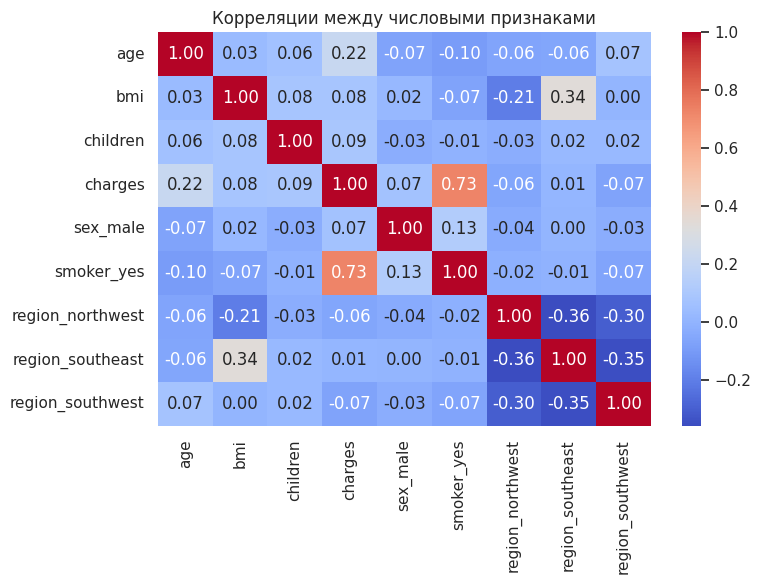

In [190]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между числовыми признаками")
plt.tight_layout()
plt.show()

In [191]:
threshold = 0.75
high_corr_pairs = [
    (col1, col2, correlation_matrix.loc[col1, col2])
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and correlation_matrix.loc[col1, col2] > threshold
]
print(high_corr_pairs)

[]


# 2

In [192]:
X_train = df_train.drop('charges', axis=1).values.astype(np.float64)
y_train = df_train['charges'].values.astype(np.float64)

X_test = df_test.drop('charges', axis=1).values.astype(np.float64)
y_test = df_test['charges'].values.astype(np.float64)

In [193]:
X_train = np.column_stack([np.ones(len(X_train)), X_train])
X_test = np.column_stack([np.ones(len(X_test)), X_test])

In [194]:
def linear_regression_analytic(X, y):
  # w = (XᵀX)^(-1) Xᵀy
  w_analytic = np.linalg.inv(X.T @ X) @ X.T @ y
  return w_analytic

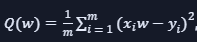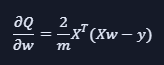

In [195]:
def linear_regression_gd(X, y, alpha=0.000001, epochs=1000):
    n_samples, n_colums = X.shape

    w = np.zeros(n_colums)

    for i in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        gradient = (2/n_samples) * (X.T @ error)
        w -= alpha * gradient
    return w

In [196]:
w_analytic = linear_regression_analytic(X_train, y_train)
w_gd = linear_regression_gd(X_train, y_train, alpha=0.0003, epochs=1000000)

feature_names = ['const'] + df.drop('charges', axis=1).columns.tolist()

print("Аналитическое решение:")
for name, weight in zip(feature_names, w_analytic.flatten()):
    print(f"{name:20s}: {weight:10.4f}")

print("\nЧисленное решение:")
for name, weight in zip(feature_names, w_gd.flatten()):
    print(f"{name:20s}: {weight:10.4f}")

Аналитическое решение:
const               : -6165.3630
age                 :   212.5472
sex                 :   232.1077
bmi                 :   578.8549
children            :  -236.9271
smoker              : 19899.3225
region              :  -927.0469

Численное решение:
const               : -6165.3566
age                 :   212.5472
sex                 :   232.1076
bmi                 :   578.8549
children            :  -236.9275
smoker              : 19899.3220
region              :  -927.0481


# 3

In [197]:
def ridge_regression_analytic(X, y, alpha):
    n_features = X.shape[1]
    I = np.eye(n_features)
    # w = (X^T*X + alpha*I)^(-1) * X^T*y
    w_ridge = np.linalg.inv((X.T @ X) + alpha * I) @ (X.T @ y)
    return w_ridge

In [198]:
def ridge_regression_gd(X, y, alpha=0.01, epochs=1000, alpha_spec=1.0):
    n_samples, n_colums = X.shape

    w = np.zeros(n_colums)

    for i in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        gradient = (2/n_samples) * (X.T @ error)
        gradient[1:] += (2 * alpha_spec / n_samples) * w[1:]
        w -= alpha * gradient
    return w

In [208]:
def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [207]:
def calculate_rmse(y_true, y_pred):
  return np.sqrt(np.mean((y_true - y_pred)**2))

In [209]:
alphas = [0.01, 0.1, 1, 10, 100, 1000]
print("Аналитическое решение:")
for alpha in alphas:
    w = ridge_regression_analytic(X_train, y_train, alpha)
    y_pred = X_test @ w
    mse = calculate_mse(y_test, y_pred)
    print(f"alpha = {alpha:<6} → MSE = {mse:.2f}")

print("\nЧисленное решение (градиентный спуск):")
for alpha in alphas:
    w = ridge_regression_gd(X_train, y_train, alpha=0.0003, epochs=1000000, alpha_spec=alpha)
    y_pred = X_test @ w
    mse = calculate_mse(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"alpha = {alpha:<6} → MSE = {mse:.2f}, RMSE = {rmse:.2f}")

Аналитическое решение:
alpha = 0.01   → MSE = 37417564.04
alpha = 0.1    → MSE = 37495532.59
alpha = 1      → MSE = 38268544.50
alpha = 10     → MSE = 45402665.90
alpha = 100    → MSE = 84733070.86
alpha = 1000   → MSE = 119391907.67

Численное решение (градиентный спуск):
alpha = 0.01   → MSE = 37414429.08, RMSE = 6116.73
alpha = 0.1    → MSE = 37464370.38, RMSE = 6120.81
alpha = 1      → MSE = 37978041.18, RMSE = 6162.63
alpha = 10     → MSE = 43917019.01, RMSE = 6626.99
alpha = 100    → MSE = 84178247.55, RMSE = 9174.87
alpha = 1000   → MSE = 120359770.35, RMSE = 10970.86


Сравнение моделей по MSE и RMSE на тестовой выборке:

Константная               → MSE = 141273995.43 | RMSE =   11885.87
Линейная (аналит.)        → MSE = 37408894.39 | RMSE =    6116.28
Линейная (GD)             → MSE = 37408897.02 | RMSE =    6116.28
Гребневая (аналит.)       → MSE = 37417564.04 | RMSE =    6116.99
Гребневая (GD)            → MSE = 37414429.08 | RMSE =    6116.73


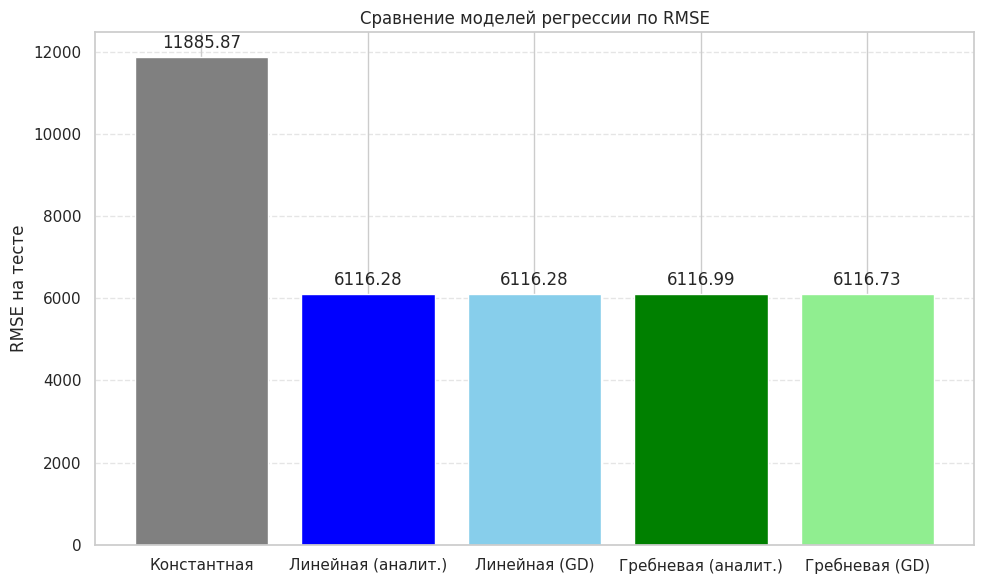

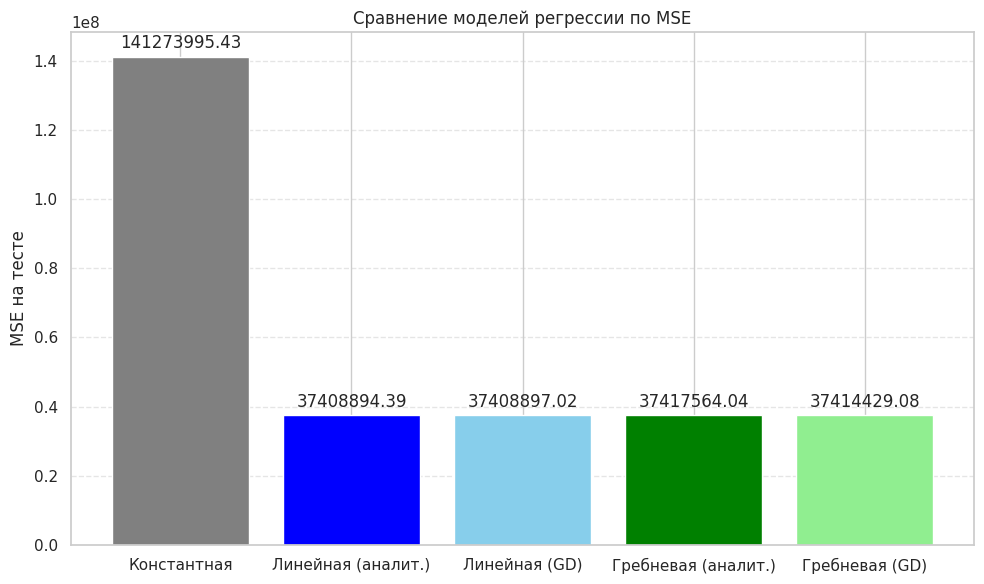

In [214]:
# Константная модель
y_pred_const = np.full_like(y_test, fill_value=np.mean(y_train))
mse_const = calculate_mse(y_test, y_pred_const)
rmse_const = calculate_rmse(y_test, y_pred_const)

# Линейная регрессия (аналитическая)
w_linear_analytic = linear_regression_analytic(X_train, y_train)
y_pred_linear_analytic = X_test @ w_linear_analytic
mse_linear_analytic = calculate_mse(y_test, y_pred_linear_analytic)
rmse_linear_analytic = calculate_rmse(y_test, y_pred_linear_analytic)

# Линейная регрессия (градиентный спуск)
w_linear_gd = linear_regression_gd(X_train, y_train, alpha=0.0003, epochs=1000000)
y_pred_linear_gd = X_test @ w_linear_gd
mse_linear_gd = calculate_mse(y_test, y_pred_linear_gd)
rmse_linear_gd = calculate_rmse(y_test, y_pred_linear_gd)

# Гребневая регрессия (аналитическая)
alpha = 0.01
w_ridge_analytic = ridge_regression_analytic(X_train, y_train, alpha)
y_pred_ridge_analytic = X_test @ w_ridge_analytic
mse_ridge_analytic = calculate_mse(y_test, y_pred_ridge_analytic)
rmse_ridge_analytic = calculate_rmse(y_test, y_pred_ridge_analytic)

# Гребневая регрессия (градиентный спуск)
w_ridge_gd = ridge_regression_gd(X_train, y_train, alpha=0.0003, epochs=1000000, alpha_spec=alpha)
y_pred_ridge_gd = X_test @ w_ridge_gd
mse_ridge_gd = calculate_mse(y_test, y_pred_ridge_gd)
rmse_ridge_gd = calculate_rmse(y_test, y_pred_ridge_gd)

model_names = [
    "Константная",
    "Линейная (аналит.)",
    "Линейная (GD)",
    "Гребневая (аналит.)",
    "Гребневая (GD)"
]
mse_values = [
    mse_const,
    mse_linear_analytic,
    mse_linear_gd,
    mse_ridge_analytic,
    mse_ridge_gd
]

rmse_values = [
    rmse_const,
    rmse_linear_analytic,
    rmse_linear_gd,
    rmse_ridge_analytic,
    rmse_ridge_gd
]

print("Сравнение моделей по MSE и RMSE на тестовой выборке:\n")
for name, mse, rmse in zip(model_names, mse_values, rmse_values):
    print(f"{name:25s} → MSE = {mse:10.2f} | RMSE = {rmse:10.2f}")

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_values, color=["gray", "blue", "skyblue", "green", "lightgreen"])
plt.ylabel("RMSE на тесте")
plt.title("Сравнение моделей регрессии по RMSE")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(rmse_values), f"{height:.2f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color=["gray", "blue", "skyblue", "green", "lightgreen"])
plt.ylabel("MSE на тесте")
plt.title("Сравнение моделей регрессии по MSE")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(mse_values), f"{height:.2f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()